# Analyze Valid Row Alignment
This notebook extracts all valid rows (i.e. such that only show walls without the ceiling or floor protruding into them which are thus useful for corner detection via wall gradients) and plots them over each other.

In [1]:
import Revise

Revise.errors()
Revise.revise()

Start MCS environment in rectangular room.

In [2]:
import PyPlot
plt = PyPlot.plt

using PyCall
@pyimport machine_common_sense as mcs
StepMetadata=mcs.StepMetadata
ObjectMetadata=mcs.ObjectMetadata

global numpy = pyimport("numpy")
@pyimport numpy as np

using Serialization
using StaticArrays
import GenGridSLAM: astar_search, backproject_grid_coord_to_world_coord, CameraIntrinsics, ccl, centroid_direction, centroid_direction_2, cloud_from_step_metadata,
    cloud_to_grid_coords, compute_frontier,
    convert_probabilistic_occupancy_grid_to_string_array, count_component_size,
    create_2d_occupancy_grid_with_segment_ids, expand_2d_occupancy_grid_dict_into_full_matrix, find_closest_unexplored_component,
    find_max_component, flip_array, generate_pddl, get_agent_grid_position_and_rotation, grid_coords_to_cloud, grid_xz_to_map_xz,
    in_grid_bounds, map_xz_to_grid_xz,
    OccupancyGrid, OccupancyGridConfig, pretty_print_occupancy_grid, pretty_print_occupancy_grid_string_array,
    print_occupancy_grid, project_3d_occupancy_grid_into_2d_dict, render_occupancy_grid, render_occupancy_grid_oriented,
    set_entry!, update_occupancy_grid!, project_3d_og_to_2d, generate_maps_2d_oriented, world_point_to_oriented_grid_coordinates

pram_path = ENV["PRAM_PATH"]
include("$(pram_path)/GenAgent/src/config/config.jl")
include("$(pram_path)/GenAgent/src/state/agent.jl")
include("$(pram_path)/GenAgent/src/submission.jl")

scene_path=joinpath(pwd(), "data/rectangular_colored_walls_empty.json")
mcs_executable_path=ENV["MCS_EXECUTABLE_PATH"]
mcs_config_path=ENV["MCS_CONFIG_FILE_PATH"]

config_data, status = mcs.load_scene_json_file(scene_path)
controller = mcs.create_controller(unity_app_file_path=mcs_executable_path,
                                   config_file_path=mcs_config_path)
step_metadata = controller.start_scene(config_data)

config = McsConfiguration()
information_level = infer_information_level(step_metadata)

intrinsics = CameraIntrinsics(step_metadata)
agent = Agent(intrinsics, [step_metadata], [],
              [Pose([0.0,0.0,0.0],  0.0, step_metadata.head_tilt)],
              [], nothing, information_level, config)

# Overwrite pram_mode so we don't need to deal with Redis etc.
agent.config.compute_configuration.pram_mode = "submission"  # usually ENV["PRAM_MODE"]

Found path: /home/falk/mitibm/AI2Thor_MCS/MCS-AI2-THOR-Unity-App-v0.4.3.x86_64


"submission"

Define functions for extracting all valid rows and retrieving all scanlines.

In [3]:
function find_scanlines(valid_index_mask)
    valid_rows = prod(valid_index_mask, dims=2)  # (400, 1) vector - pick index with value 1
    valid_indices = []
    for row_idx in 1:size(valid_rows)[1]
        if valid_rows[row_idx]
            push!(valid_indices, row_idx)
        end
    end
    return valid_indices
end

"""
Same as `get_scanline()`, but works on camera frame point cloud
without depending on global coordinates. Based on `detect_corner_from_camera_frame(agent)`.
"""
function get_scanline_from_camera_frame(agent::Agent, intrinsics::CameraIntrinsics;
        verbose = false)
    
    step_metadata = agent.step_metadatas[end]
    
    cloud = cloud_from_depth_map(
                Matrix(numpy.array(last(step_metadata.depth_map_list))),
                intrinsics.cx, intrinsics.cy,
                intrinsics.fx, intrinsics.fy,
                intrinsics.width, intrinsics.height; stride_x=1, stride_y=1
            )
    cloud_array_2d = reshape(cloud, (3, size(agent.step_metadatas[end].depth_map_list[end])...))
    
    # We could get point cloud in world frame like this, but don't know our pose after kidnapping:
    # pose = agent.poses[end]
    # cloud = rotate_cloud(cloud; head_tilt_deg=pose.head_tilt, view_angle_deg=pose.rotation)
    # cloud = translate_cloud(cloud, pose.position)
    # cloud_array_2d_b = reshape(cloud, (3, size(agent.step_metadatas[end].depth_map_list[end])...));
    
    height_offset = 0.1
    min_height, max_height = minimum(cloud[2, :]) + height_offset, maximum(cloud[2, :]) - height_offset
    if verbose println("Height range: $(min_height) to $(max_height)") end

    # Boolean mask for all pixels that are definitely not ceiling or floor
    valid_indices = (cloud[2,:] .> min_height) .& (cloud[2,:] .< max_height)
    valid_indices_2d = reshape(valid_indices, size(agent.step_metadatas[end].depth_map_list[end]))

    scanline_idx = find_scanlines(valid_indices_2d)
    
    return cloud_array_2d, scanline_idx
end

get_scanline_from_camera_frame

Rotate s.t. corner is in view instead of just straight wall.

Plotted 263 rows.
Plotted 253 rows.
Plotted 241 rows.
Plotted 235 rows.
Plotted 225 rows.
Plotted 219 rows.


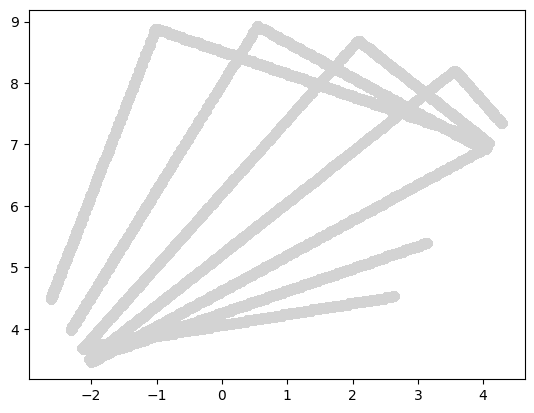

Plotted 220 rows.


In [4]:
for i in 1:7
    execute_command(controller, agent, "RotateRight")
    # Could plot all valid lines for each step
#     cloud_array_2d, scanline_indices = get_scanline_from_camera_frame(agent, intrinsics)
#     rois = []
#     for scanline_idx in scanline_indices
#         roi = cloud_array_2d[1:3, scanline_idx, :]
#         push!(rois, roi)
#         plt.scatter(roi[1,:], roi[3,:], c="lightgray", marker="o")
#     end
#     println("Plotted $(length(scanline_indices)) rows.")
end

Get point cloud as `(3, 400, 600)` array as well as valid indices of rows that exclusively show walls. Then iterate over valid rows and plot their (x,z)-coordinates.

In [ ]:
cloud_array_2d, scanline_indices = get_scanline_from_camera_frame(agent, intrinsics)
rois = []
for scanline_idx in scanline_indices
    roi = cloud_array_2d[1:3, scanline_idx, :]
    push!(rois, roi)
    plt.scatter(roi[1,:], roi[3,:], c="lightgray", marker="o")
end
println("Plotted $(length(scanline_indices)) rows.")

Additionally, compute average distance for x, y and z coordinates between first and last valid row. `x` and `z` differences should be close to `0` if the valid rows are aligned well and `y` approximately `3` if the entire room is in view, since the height goes from `0` to `3`.

In [ ]:
x_diff = sum(rois[1][1,:]-rois[length(scanline_indices)][1,:]) / length(rois[220][3,:])
y_diff = sum(rois[1][2,:]-rois[length(scanline_indices)][2,:]) / length(rois[220][3,:])
z_diff = sum(rois[1][3,:]-rois[length(scanline_indices)][3,:]) / length(rois[220][3,:])
println("Avg. difference between first and last valid row in x: $(x_diff), y: $(y_diff), z: $(z_diff)")

Show both depth image and then highlight all valid rows.

In [ ]:
plt.imshow(agent.step_metadatas[end].depth_map_list[end])

In [ ]:
validation_map = copy(agent.step_metadatas[end].depth_map_list[end])
for scanline_idx in scanline_indices
    validation_map[scanline_idx, :] .= 0
end
plt.imshow(validation_map)

In [ ]:
function find_closest_row(scanline_indices, target_row::Int = 200)
    min_distance = 99999
    row = -1
    for scanline_idx in scanline_indices
        current_distance = abs(scanline_idx - target_row)
        if current_distance < min_distance
            min_distance = current_distance
            row = scanline_idx
        end
    end
    
    return row, min_distance
end

a, b = find_closest_row(scanline_indices)
println("Closest row to target index 200: $(a), distance to target $(b).")